$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 5: Convolutional Architecture Experiments
<a id=part5></a>

In this part we will explore convolution networks and the effects of their architecture on accuracy. We'll use our deep CNN implementation and perform various experiments on it while varying the architecture. Then we'll implement our own custom architecture to see whether we can get high classification results on a large subset of CIFAR-10.

Training will be performed on GPU.

In [6]:
import os
import re
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import unittest
import torch
import torchvision
import torchvision.transforms as tvtf

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [7]:
seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.rcParams.update({'font.size': 12})
test = unittest.TestCase()

## Experimenting with model architectures
<a id=part5_3></a>

We will now perform a series of experiments that train various model configurations on a part of the CIFAR-10 dataset.

To perform the experiments, you'll need to use a machine with a GPU since training time might be too long otherwise.


### Note about running on GPUs

Here's an example of running a forward pass on the GPU
(assuming you're running this notebook on a GPU-enabled machine).

In [10]:
from hw2.cnn import ResNet

net = ResNet(
    in_size=(3,100,100), out_classes=10, channels=[32, 64]*3,
    pool_every=4, hidden_dims=[100]*2,
    pooling_type='avg', pooling_params=dict(kernel_size=2),
)
net = net.to(device)

test_image = torch.randint(low=0, high=256, size=(3, 100, 100), dtype=torch.float).unsqueeze(0)
test_image = test_image.to(device)

test_out = net(test_image)

<class 'torch.device'>


Notice how we called `.to(device)` on **both** the model and the input tensor.
Here the `device` is a `torch.device` object that we created above. If an nvidia GPU is available on the machine you're running this on, the `device` will be `'cuda'`. When you run `.to(device)` on a model, it recursively goes over all the model parameter tensors and copies their memory to the GPU. Similarly, calling `.to(device)` on the input image also copies it.

In order to train on a GPU, you need to make sure to move **all** your tensors to it. You'll get errors if you try to mix CPU and GPU tensors in a computation.

In [7]:
print(f'This notebook is running with device={device}')
print(f'The model parameter tensors are also on device={next(net.parameters()).device}')
print(f'The test image is also on device={test_image.device}')
print(f'The output is therefore also on device={test_out.device}')

This notebook is running with device=cpu
The model parameter tensors are also on device=cpu
The test image is also on device=cpu
The output is therefore also on device=cpu


### Notes on using course servers

First, please read the [course servers guide](https://vistalab-technion.github.io/cs236781/assignments/hpc-servers) carefully.

To run the experiments on the course servers, you can use the `py-sbatch.sh` script directly to perform a single experiment run in batch mode (since it runs python once), or use the `srun` command to do a single run in interactive mode. For example, running a single run of experiment 1 interactively (after `conda activate` of course):

```shell
srun -c 2 --gres=gpu:1 --pty python -m hw2.experiments run-exp -n test -K 32 64 -L 2 -P 2 -H 100
```

To perform multiple runs in batch mode with `sbatch` (e.g. for running all the configurations of an experiments), you can create your own script based on `py-sbatch.sh` and invoke whatever commands you need within it.

Don't request more than **2 CPU** cores and **1 GPU** device for your runs. The code won't be able to utilize more than that anyway, so you'll see no performance gain if you do. It will only cause delays for other students using the servers.

### General notes for running experiments

- You can run the experiments on a different machine (e.g. the course servers) and copy the results (files)
  to the `results` folder on your local machine.
  This notebook will only display the results, not run the actual experiment code (except for a demo run).
- It's important to give each experiment run a name as specified by the notebook instructions later on.
  Each run has a `run_name` parameter that will also be the base name of the results file which this 
  notebook will expect to load.
- You will implement the code to run the experiments in the `hw2/experiments.py` module.
  This module has a CLI parser so that you can invoke it as a script and pass in all the
  configuration parameters for a single experiment run.
- You should use `python -m hw2.experiments run-exp` to run an experiment, and **not**
  `python hw2/experiments.py run-exp`, regardless of how/where you run it.

### Experiment 1: Network depth and number of filters

In this part we will test some different architecture configurations based on our `CNN` and `ResNet`.
Specifically, we want to try different depths and number of features to see the effects these parameters have on the model's performance.

To do this, we'll define two extra hyperparameters for our model, `K` (`filters_per_layer`) and `L` (`layers_per_block`).
- `K` is a list, containing the number of filters we want to have in our conv layers.
- `L` is the number of consecutive layers with the same number of filters to use.

For example, if `K=[32, 64]` and `L=2` it means we want two conv layers with 32 filters followed by two conv layers with 64 filters. If we also use `pool_every=3`, the feature-extraction part of our model will be:

    Conv(X,32)->ReLu->Conv(32,32)->ReLU->Conv(32,64)->ReLU->MaxPool->Conv(64,64)->ReLU
    
We'll try various values of the `K` and `L` parameters in combination and see how each architecture trains. **All other hyperparameters are up to you**, including the choice of the optimization algorithm, the learning rate, regularization and architecture hyperparams such as `pool_every` and `hidden_dims`. Note that you should select the `pool_every` parameter wisely per experiment so that you don't end up with zero-width feature maps.

You can try some short manual runs to determine some good values for the hyperparameters or implement cross-validation to do it. However, the **dataset size** you test on should be large. If you limit the number of batches, make sure to use at least 30000 training images and 5000 validation images.

The important thing is that you state what you used, how you decided on it, and explain your results based on that.

First we need to write some code to run the experiment.

**TODO**:
1. Implement the `cnn_experiment()` function in the `hw2/experiments.py` module.
1. If you haven't done so already, it would be an excellent idea to implement the **early stopping** feature of the `Trainer` class.

The following block tests that your implementation works. It's also meant to show you that each experiment run creates a result file containing the parameters to reproduce and the `FitResult` object for plotting.

Files already downloaded and verified
Files already downloaded and verified
<class 'torch.device'>
--- EPOCH 1/10 ---


[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 2/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 3/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 4/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 5/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 6/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 7/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 8/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 9/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 10/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

*** Output file ./results/test_run_L1_K32-64.json written
experiment config:  {'run_name': 'test_run', 'out_dir': './results', 'seed': 42, 'device': None, 'bs_train': 50, 'bs_test': 12, 'batches': 10, 'epochs': 10, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'filters_per_layer': [32, 64], 'layers_per_block': 1, 'pool_every': 1, 'hidden_dims': [100], 'model_type': 'resnet', 'kw': {}}


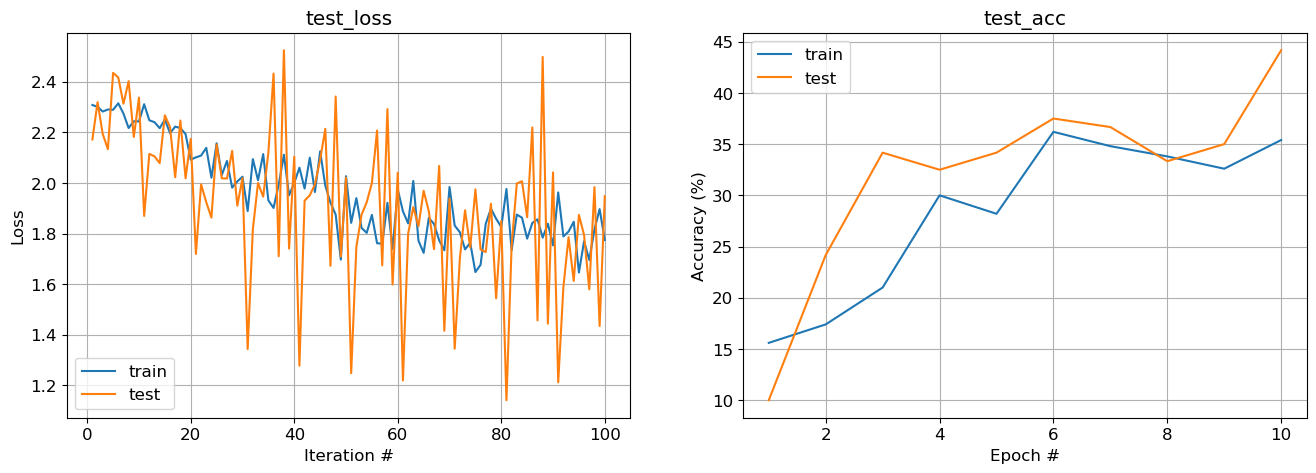

In [12]:
from hw2.experiments import load_experiment, cnn_experiment
from cs236781.plot import plot_fit

# Test experiment1 implementation on a few data samples and with a small model
cnn_experiment(
    'test_run', seed=seed, bs_train=50, batches=10, epochs=10, early_stopping=5,
    filters_per_layer=[32,64], layers_per_block=1, pool_every=1, hidden_dims=[100],
    model_type='resnet',
)

# There should now be a file 'test_run.json' in your `results/` folder.
# We can use it to load the results of the experiment.
cfg, fit_res = load_experiment('results/test_run_L1_K32-64.json')
_, _ = plot_fit(fit_res, train_test_overlay=True)

# And `cfg` contains the exact parameters to reproduce it
print('experiment config: ', cfg)

In [2]:

# Test experiment1 implementation on a few data samples and with a small model
cnn_experiment(
    'test_run', seed=seed, bs_train=128, batches=10, epochs=100, early_stopping=3,
    filters_per_layer=[32,64], layers_per_block=8, pool_every=1, hidden_dims=[100],
    model_type='resnet',
)

# There should now be a file 'test_run.json' in your `results/` folder.
# We can use it to load the results of the experiment.
cfg, fit_res = load_experiment('results/test_run_L1_K32-64.json')
_, _ = plot_fit(fit_res, train_test_overlay=True)

# And `cfg` contains the exact parameters to reproduce it
print('experiment config: ', cfg)

NameError: name 'cnn_experiment' is not defined

We'll use the following function to load multiple experiment results and plot them together.

In [13]:
def plot_exp_results(filename_pattern, results_dir='results'):
    fig = None
    result_files = glob.glob(os.path.join(results_dir, filename_pattern))
    result_files.sort()
    if len(result_files) == 0:
        print(f'No results found for pattern {filename_pattern}.', file=sys.stderr)
        return
    for filepath in result_files:
        m = re.match('exp\d_(\d_)?(.*)\.json', os.path.basename(filepath))
        cfg, fit_res = load_experiment(filepath)
        fig, axes = plot_fit(fit_res, fig, legend=m[2],log_loss=True)
    del cfg['filters_per_layer']
    del cfg['layers_per_block']
    print('common config: ', cfg)

#### Experiment 1.1: Varying the network depth (`L`)

First, we'll test the effect of the network depth on training.

**Configuratons**:
- `K=32` fixed, with `L=2,4,8,16` varying per run
- `K=64` fixed, with `L=2,4,8,16` varying per run

So 8 different runs in total.

**Naming runs**:
Each run should be named `exp1_1_L{}_K{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_1_L2_K32`. 

**TODO**: Run the experiment on the above configuration with the `CNN` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_1_L8_K32', 'out_dir': './results', 'seed': 1382571000, 'device': None, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 16, 'hidden_dims': [100], 'model_type': 'cnn', 'kw': {}}


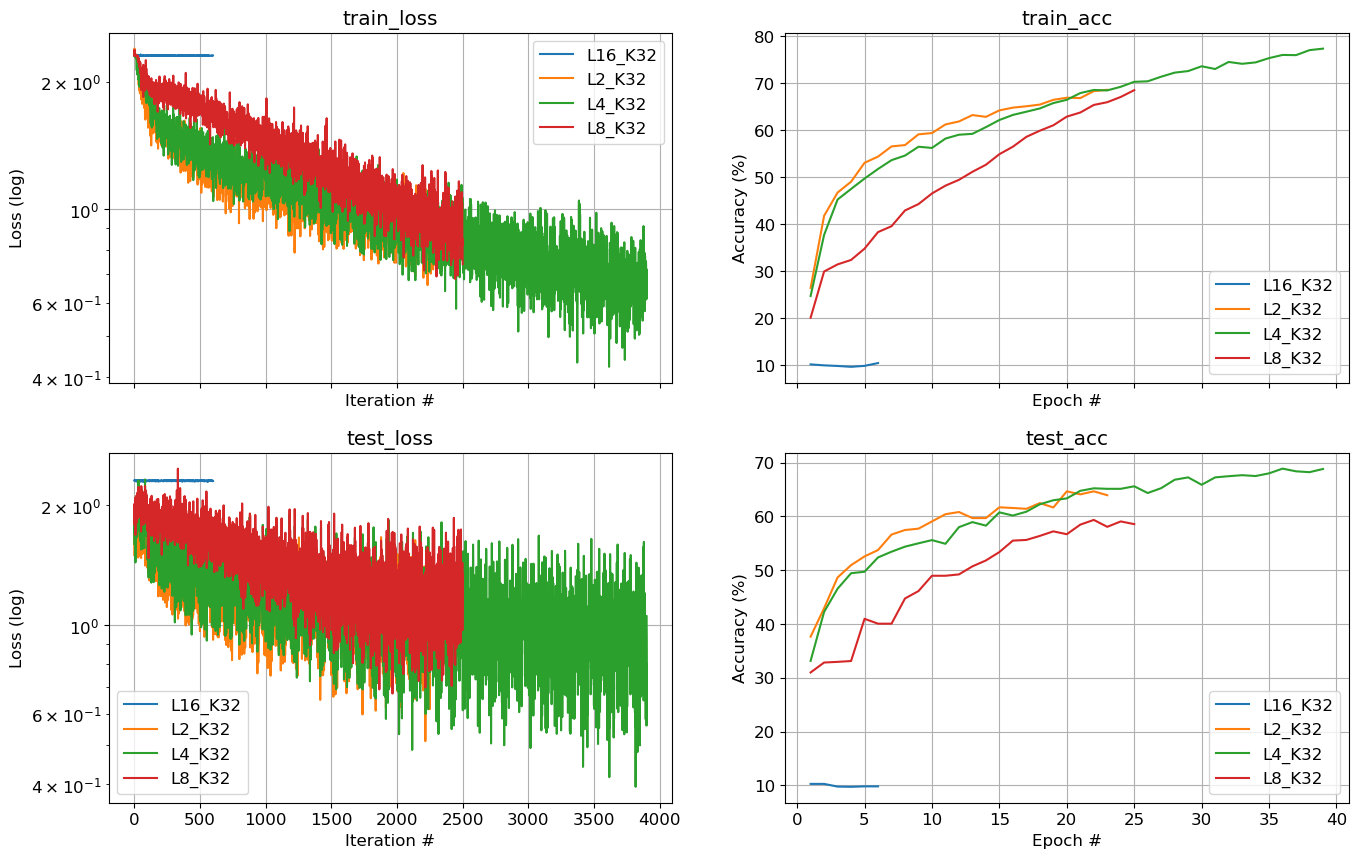

In [14]:
plot_exp_results('exp1_1_L*_K32*.json')

common config:  {'run_name': 'exp1_1_L8_K64', 'out_dir': './results', 'seed': 1834631084, 'device': 'mps', 'bs_train': 100, 'bs_test': 24, 'batches': 500, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 8, 'hidden_dims': [1000], 'model_type': 'cnn', 'kw': {}}


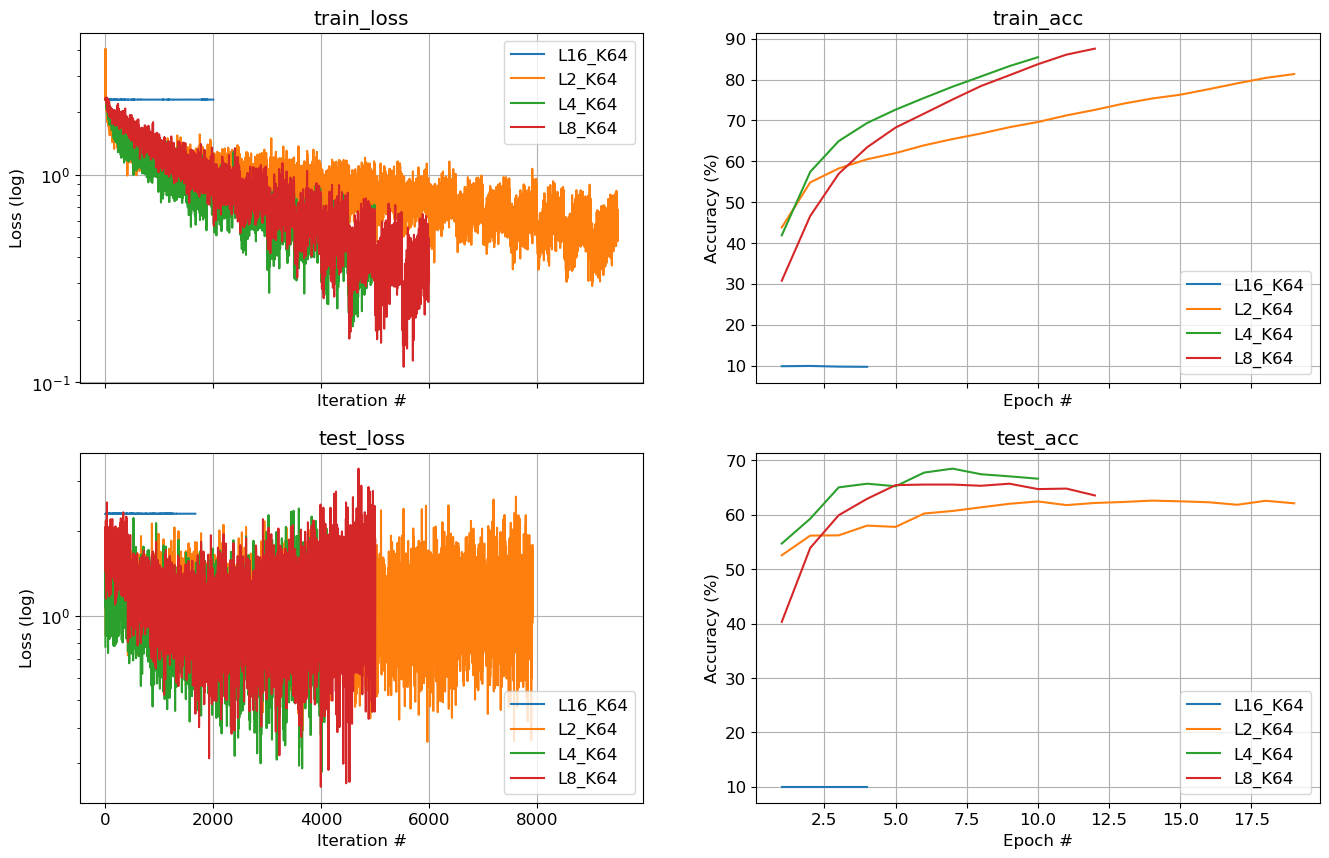

In [15]:
plot_exp_results('exp1_1_L*_K64*.json')

#### Experiment 1.2: Varying the number of filters per layer (`K`)

Now we'll test the effect of the number of convolutional filters in each layer.

**Configuratons**:
- `L=2` fixed, with `K=[32],[64],[128]` varying per run.
- `L=4` fixed, with `K=[32],[64],[128]` varying per run.
- `L=8` fixed, with `K=[32],[64],[128]` varying per run.

So 9 different runs in total. To clarify, each run `K` takes the value of a list with a single element.

**Naming runs**:
Each run should be named `exp1_2_L{}_K{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_2_L2_K32`. 

**TODO**: Run the experiment on the above configuration with the `CNN` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_2', 'out_dir': './results', 'seed': 1760725722, 'device': 'mps', 'bs_train': 100, 'bs_test': 24, 'batches': 100, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 4, 'hidden_dims': [100], 'model_type': 'cnn', 'kw': {}}


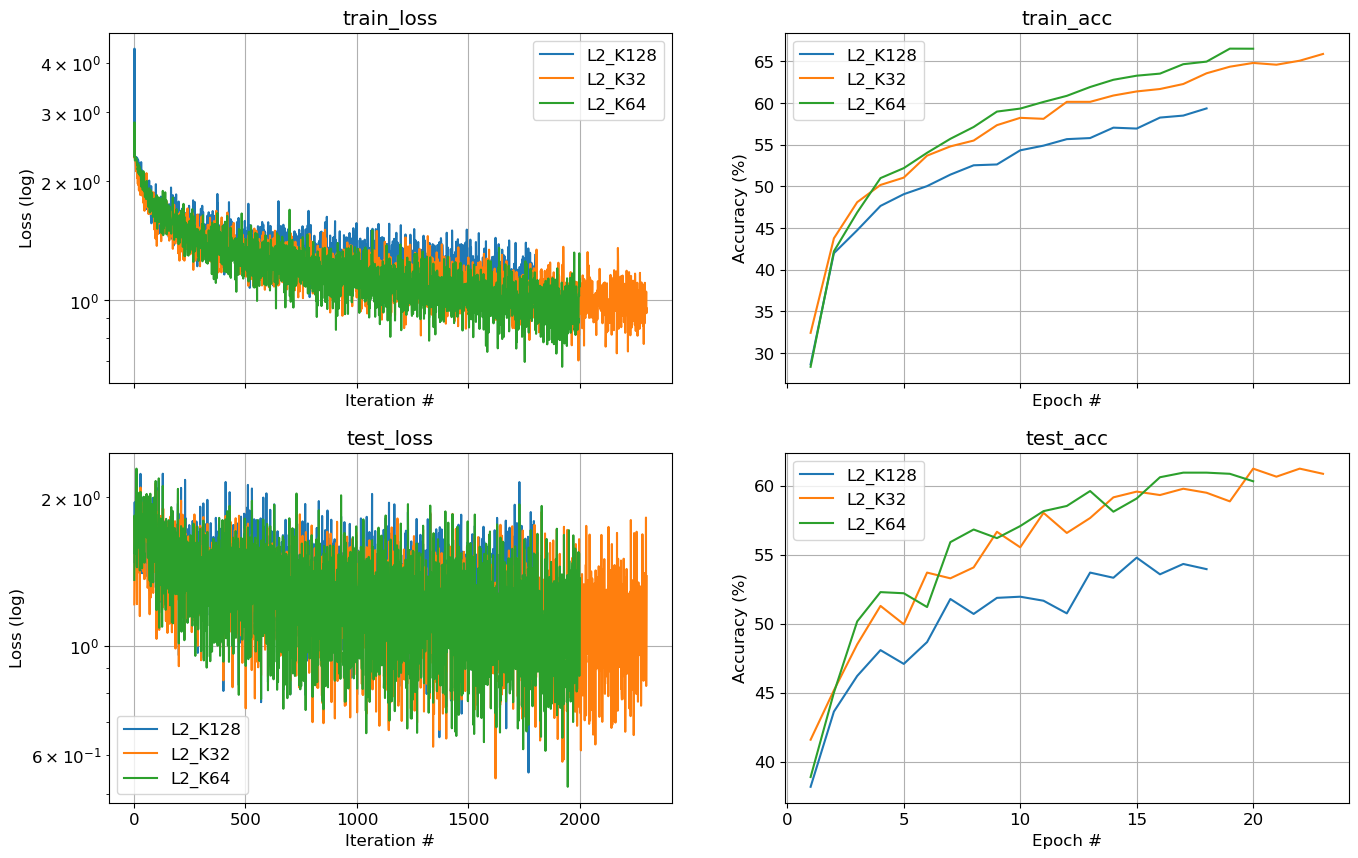

In [16]:
plot_exp_results('exp1_2_L2*.json')

common config:  {'run_name': 'exp1_2', 'out_dir': './results', 'seed': 195448196, 'device': 'mps', 'bs_train': 100, 'bs_test': 24, 'batches': 100, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 4, 'hidden_dims': [100], 'model_type': 'cnn', 'kw': {}}


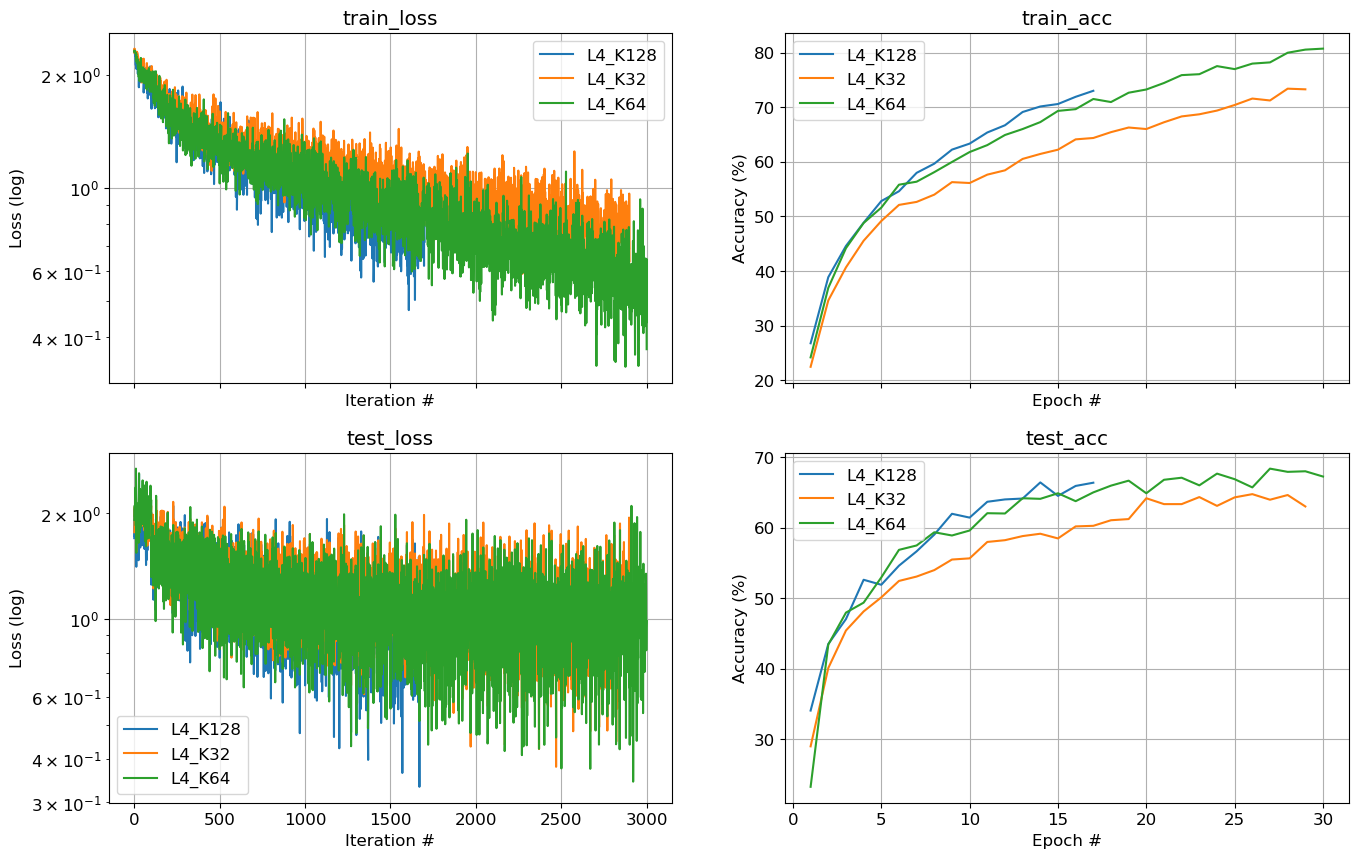

In [17]:
plot_exp_results('exp1_2_L4*.json')

common config:  {'run_name': 'exp1_2', 'out_dir': './results', 'seed': 775362814, 'device': 'mps', 'bs_train': 100, 'bs_test': 24, 'batches': 500, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.0001, 'reg': 0.0001, 'pool_every': 4, 'hidden_dims': [1000], 'model_type': 'cnn', 'kw': {}}


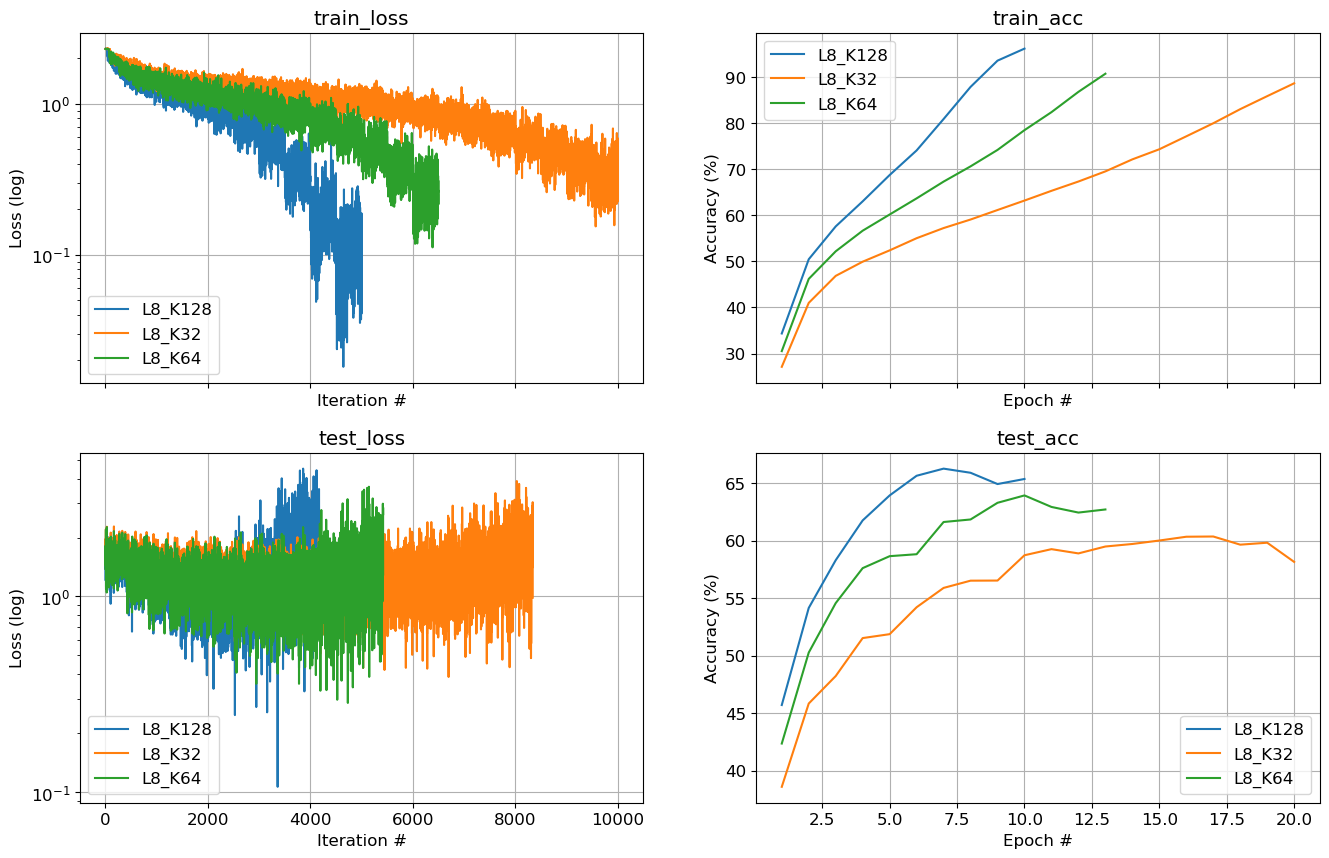

In [18]:
plot_exp_results('exp1_2_L8*.json')

#### Experiment 1.3: Varying both the number of filters (`K`) and network depth (`L`)

Now we'll test the effect of the number of convolutional filters in each layer.

**Configuratons**:
- `K=[64, 128]` fixed with `L=2,3,4` varying per run.

So 3 different runs in total. To clarify, each run `K` takes the value of an array with a two elements.

**Naming runs**:
Each run should be named `exp1_3_L{}_K{}-{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_3_L2_K64-128`. 

**TODO**: Run the experiment on the above configuration  with the `CNN` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_3_L4_K64-128', 'out_dir': './results', 'seed': 106298334, 'device': 'mps', 'bs_train': 50, 'bs_test': 12, 'batches': 100, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.0001, 'reg': 0.0001, 'pool_every': 4, 'hidden_dims': [100], 'model_type': 'cnn', 'kw': {}}


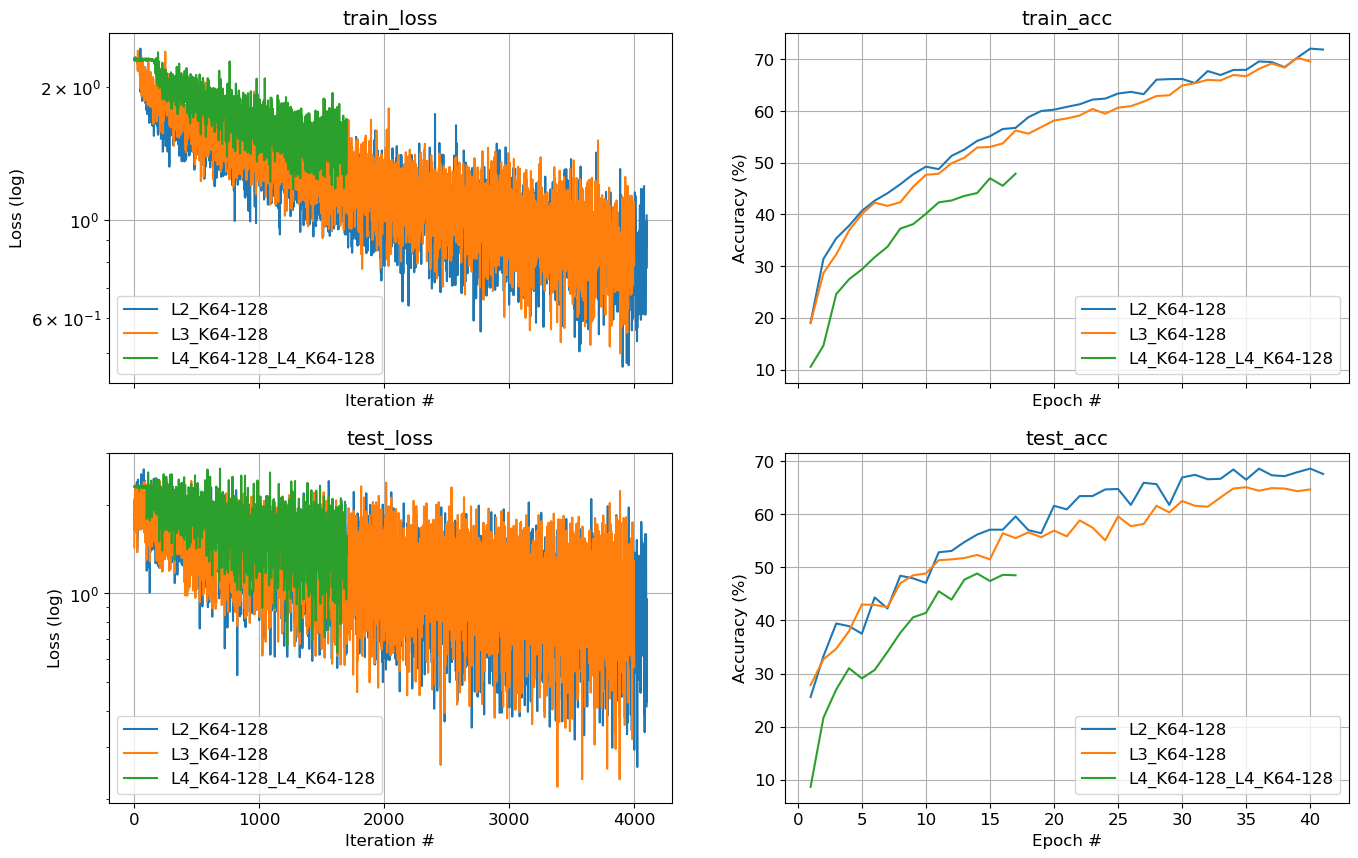

In [19]:
plot_exp_results('exp1_3*.json')

#### Experiment 1.4: Adding depth with Residual Networks

Now we'll test the effect of skip connections on the training and performance.

**Configuratons**:
- `K=[32]` fixed with `L=8,16,32` varying per run.
- `K=[64, 128, 256]` fixed with `L=2,4,8` varying per run.

So 6 different runs in total.

**Naming runs**:
Each run should be named `exp1_4_L{}_K{}-{}-{}` where the braces are placeholders for the values.

**TODO**: Run the experiment on the above configuration with the `ResNet` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_4', 'out_dir': './results', 'seed': 1068849501, 'device': 'mps', 'bs_train': 100, 'bs_test': 24, 'batches': 100, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 4, 'hidden_dims': [100], 'model_type': 'resnet', 'kw': {}}


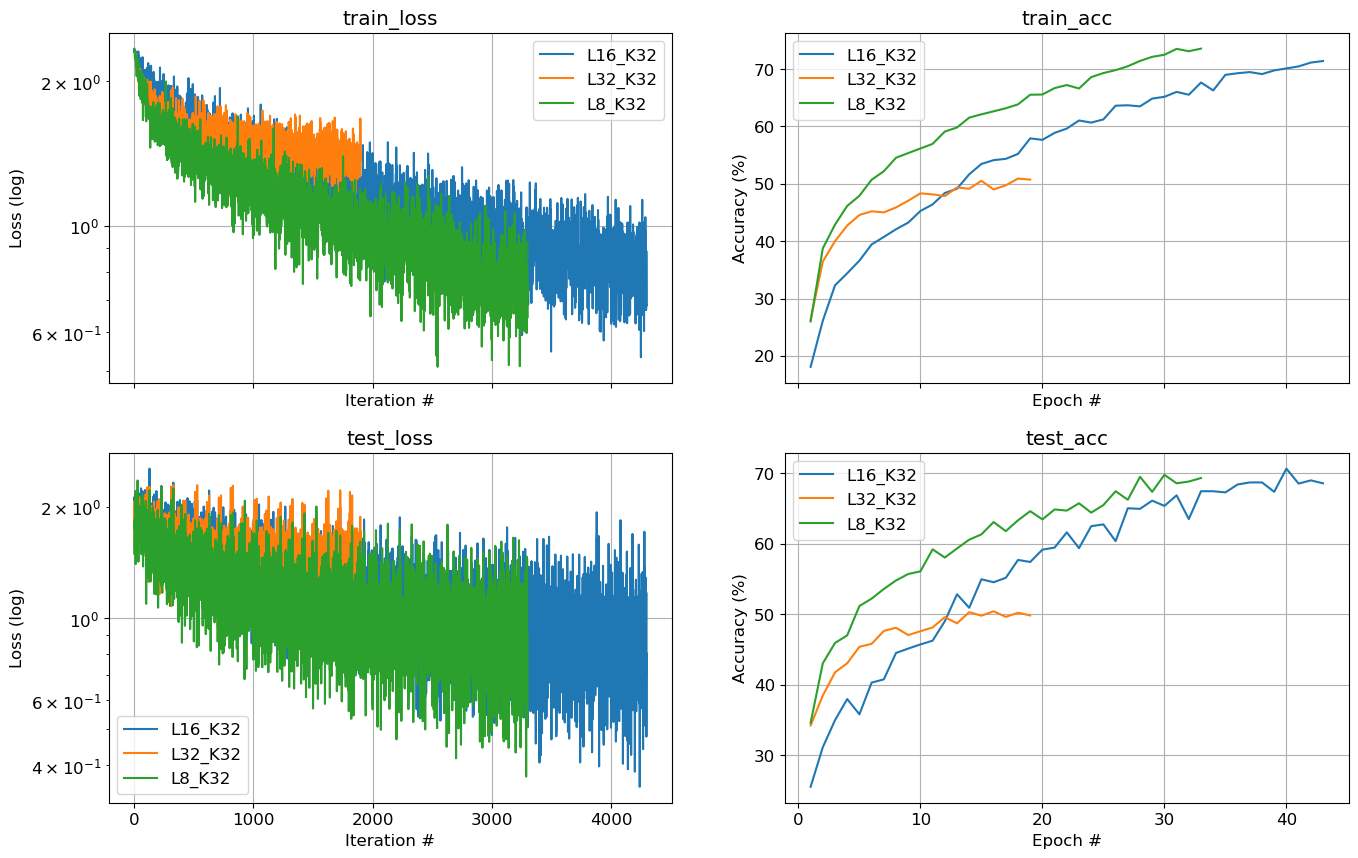

In [20]:
plot_exp_results('exp1_4_L*_K32.json')

common config:  {'run_name': 'exp1_4', 'out_dir': './results', 'seed': 1447812970, 'device': 'mps', 'bs_train': 100, 'bs_test': 24, 'batches': 10, 'epochs': 100, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 16, 'hidden_dims': [100], 'model_type': 'cnn', 'kw': {}}


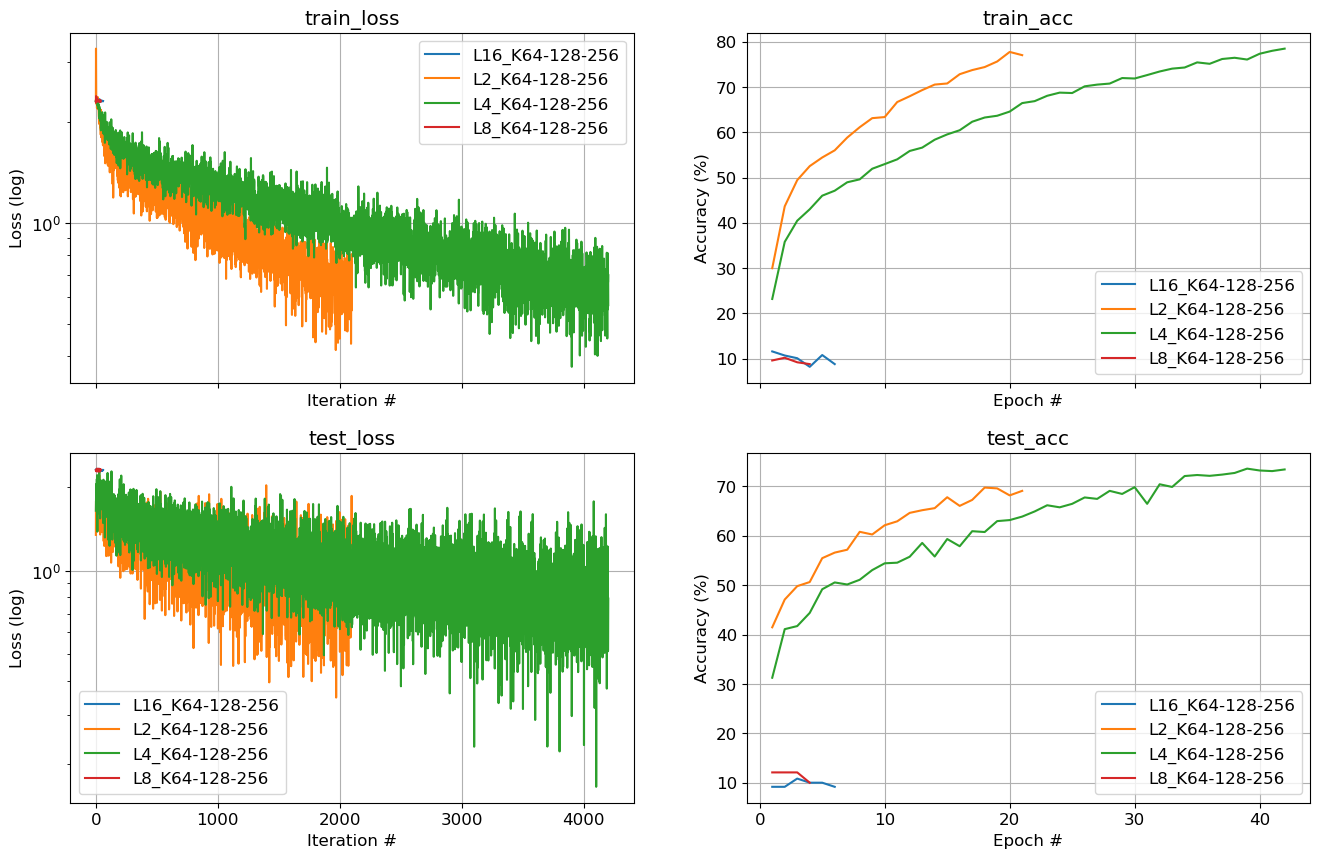

In [21]:
plot_exp_results('exp1_4_L*_K64*.json')

## Questions
<a id=part5_4></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw2/answers.py`.

In [1]:
from cs236781.answers import display_answer
import hw2.answers

### Question 1 

Analyze your results from experiment 1.1. In particular,
1.  Explain the effect of depth on the accuracy. What depth produces the best results and why do you think that's the case?
1. Were there values of `L` for which the network wasn't trainable? what causes this? Suggest two things which may be done to resolve it at least partially.

In [2]:
display_answer(hw2.answers.part5_q1)


**Part 1.** 

From the results, the depth of the model, controlled by the number of layers (L), has a significant effect on accuracy:

Shallow Models (L=2): Perform reasonably well initially but tend to underfit the data compared to deeper models, especially as the complexity of the task increases. This is evident in the lower test accuracy over epochs.
Moderate Depth (L=4): Strikes a balance and often achieves the best accuracy across training and testing. This depth seems to provide sufficient capacity to learn complex features without overfitting.
Deeper Models (L=8): While they can achieve high training accuracy, their test accuracy may degrade, suggesting overfitting. Additionally, the loss values exhibit high variance and instability, especially during training.
Best Depth: Based on the graphs, L=4 provides the best trade-off between training and test accuracy. This depth likely balances the ability to learn intricate patterns while avoiding overfitting or becoming too complex for effective training.

---

**Part 2:**

Untrainable Networks (L=16): The results show that for very deep networks (L=16), the model struggles to train, as indicated by stagnant accuracy and loss values.
Causes:

Vanishing/Exploding Gradients: Deeper networks are prone to gradient issues during backpropagation, making it hard for the model to update weights effectively.
Overparameterization: Excessive parameters can lead to inefficient training and difficulty in optimizing the loss function.
Small Feature Maps: If pool_every is not set correctly, deeper layers may encounter zero-width or near-zero-width feature maps, leading to issues in the forward pass.

Recommendations to Resolve Trainability Issues:

1: Gradient Stabilization:

Use batch normalization or layer normalization to normalize inputs to each layer, mitigating the vanishing/exploding gradient problem.
Adopt residual connections (ResNet architecture) to enable better gradient flow in deep networks.

2: Adjust Hyperparameters:

Use smaller learning rates with adaptive optimizers (e.g., Adam or RMSprop) to stabilize training for deep networks.
Reevaluate pool_every to ensure feature maps do not shrink too early or become too small.



### Question 2 

Analyze your results from experiment 1.2. In particular, compare to the results of experiment 1.1.

In [3]:
display_answer(hw2.answers.part5_q2)


**Observations**

**Effect of K on L=2 Configurations**
1. **Higher Filters Improve Accuracy**:  
   As `K` increases, there is a noticeable improvement in test accuracy.  
   This suggests that adding more filters enables the shallow network to capture richer features.

2. **Overfitting in High K (L2_K128)**:  
   The configuration with `K=128` overfits quickly.  
   Evidence includes rapid convergence and limited improvement on the test set.

3. **Difficulty Controlling Training Dynamics**:  
   Early stopping was necessary to prevent overfitting.  
   Attempts to use adaptive learning rates were unsuccessful in stabilizing training.

**Effect of K on L=4 Configurations**
1. **Balanced Depth and Filters Work Best**:  
   The `L4_K64` configuration provided the best performance.  
   Achieved a good balance between capacity and generalization.

2. **Overfitting in High K (L4_K128)**:  
   Similar to `L=2`, the higher filter configuration showed signs of overfitting.  
   However, its overall performance was more stable compared to `L2_K128`.

**Effect of K on L=8 Configurations**
1. **Reduced Performance Compared to Shallower Networks**:  
   The deeper `L=8` configurations consistently underperformed compared to `L=4` and `L=2`.  
   Likely due to the vanishing gradient problem and difficulty in optimizing deep networks without additional techniques (e.g., residual connections).

2. **High Variance in Training Loss**:  
   The loss curves for `L8` configurations, especially `L8_K128`, exhibited significant variance.  
   Indicates instability in training.

---

**Comparison to Experiment 1.1**

1. **Consistency in Optimal Depth**:  
   Similar to Experiment 1.1, the `L=4` configuration outperformed both shallower (`L=2`) and deeper (`L=8`) networks.

2. **Performance of L=8 Remains Poor**:  
   Issues with trainability and performance of the `L=8` configurations were evident in both experiments.  
   Reinforces the need for architectural adjustments (e.g., residual connections) to make deeper networks more effective.

3. **Filters (K) Complement Depth**:  
   Experiment 1.2 highlights that increasing `K` can improve performance in shallow and moderately deep networks.  
   However, the benefits diminish in deeper networks due to optimization challenges.








### Question 3 

Analyze your results from experiment 1.3.

In [4]:
display_answer(hw2.answers.part5_q3)



**Analysis of part 3:**
    **Best Configuration:** The `L=2` configuration with `K=[64, 128]` achieved the highest test accuracy (~65.54%), outperforming deeper networks.
    **Moderate Depths:** The `L=3` configuration had slightly lower accuracy (~64.01%), showing diminishing returns from additional depth.
    **Overfitting in Deep Networks:** The `L=4` configuration exhibited overfitting, with accuracy peaking (~64.25%) before declining.
    **Effect of High Filters:** Higher filters (`K=128`) accelerated overfitting, especially in deeper networks.

**Insights**
    **Generalization:** Shallower networks (`L=2`) generalize better and are more stable during training.
    **Diminishing Returns:** Deeper networks face diminishing returns due to overfitting and gradient issues.
    **Filter Counts:** While higher filters improve capacity, they also increase overfitting risks.



### Question 4

Analyze your results from experiment 1.4. Compare to experiment 1.1 and 1.3.

In [5]:
display_answer(hw2.answers.part5_q4)


**Analysis of part 4:**



**Impact of Residual Connections:**
    Residual connections improved training stability in deeper networks (`L=16`, `L=32`) for `K=[32]`, resolving vanishing gradients observed in Experiment 1.1.
    Test accuracy improved for moderate depths (`L=8`) but plateaued or slightly decreased for very deep networks (`L=16`, `L=32`), indicating diminishing returns.

**Performance with High Filters (`K=[64, 128, 256]`):**
    Shallow networks (`L=2`) achieved the highest test accuracy, consistent with Experiment 1.3.
    Moderate depths (`L=4`) performed well but showed overfitting as depth increased.
    Deeper configurations (`L=8`) were more stable with residuals but did not outperform shallower networks in test accuracy, likely due to overfitting.

**More Comparisons to Experiments 1.1 and 1.3:**
    Residual connections resolved instability in deeper networks that we had in 1.3, enabling effective training up to `L=32`.
    Shallower networks (`L=2`, `L=4`) still generalized better, with limited benefits from additional depth even with residuals.
    High filter counts (`K`) accelerated overfitting, though residual connections mitigated this somewhat.

**Insights**
    Effectiveness of Residual Connections: Essential for training deep networks, preventing vanishing gradients and improving stability.
    Optimal Depth: Moderate depths (`L=4`, `L=8`) balance capacity and generalization, while very deep networks (`L=16`, `L=32`) face diminishing returns.
    Filter Counts and Overfitting: Higher filters enhance representation capacity but increase overfitting risks, which residual connections help to mitigate but not eliminate.



In [5]:
display_answer(hw2.answers.part5_q5)


AttributeError: module 'hw2.answers' has no attribute 'part5_q5'